**STATISTICAL LEARNING AND NEURAL NETWORKS, A.A. 2022/2023**

**COMPUTER LAB 4** - Kalman filter

**Duration: 3 hours**

**Introduction:**

In this lab, you are provided with the set of coordinates (x,y – horizontal and vertical) describing the trajectories of pedestrians moving acrooss a scene. Your task is to simulate the observed positions of the pedestrians by adding observation noise, then to track the subjects using a Kalman filter. In other words, you need to estimate the next (x,y) positions, from the observations of the previous positions.


*Simulating the observed coordinates*

Choose one of the trajectories in the dataset. This data will be considered the real trajectory. Generate the observed directory by adding observation noise $\delta_t \sim \mathcal{N}(0,\sigma^{2}_{R})$ to the (x,y) coordinates.


*Designing the Kalman filter*

Your task is to **design a Kalman filter** based on a constant velocity model, which tracks the next (x,y) position of the object, from the observation of the previous positions. The code must be based on the following model.

*   The state vector contains coordinates and velocities: $z^{T}_{t} = (z_{1t}, z_{2t}, v_{1t}, v_{2t})$ (see slides). The object has initial coordinates (0,0) and velocity $(\Delta,Δ)$.
*   Only the coordinates (but not the velocities) are observed. This leads to a linear dynamical system with:

$A = \left( \begin{matrix} 1 & 0 & \Delta & 0 \\ 0 & 1 & 0 & \Delta \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$


$C = \left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{matrix} \right)$

and B = D = 0.

*   $\Sigma_{Q}$, and $\Sigma_{R}$ should be set to:

$\Sigma_{Q} = \sigma^{2}_{Q}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

$\Sigma_{R} = \sigma^{2}_{R}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

To see if your Kalman filter is working well, you should plot the estimated position of the object over time with respect to the true position (i.e., the first two entries of the state vector) and the observed position. Depending on the chosen parameters, for each coordinate the graph may look something like this:

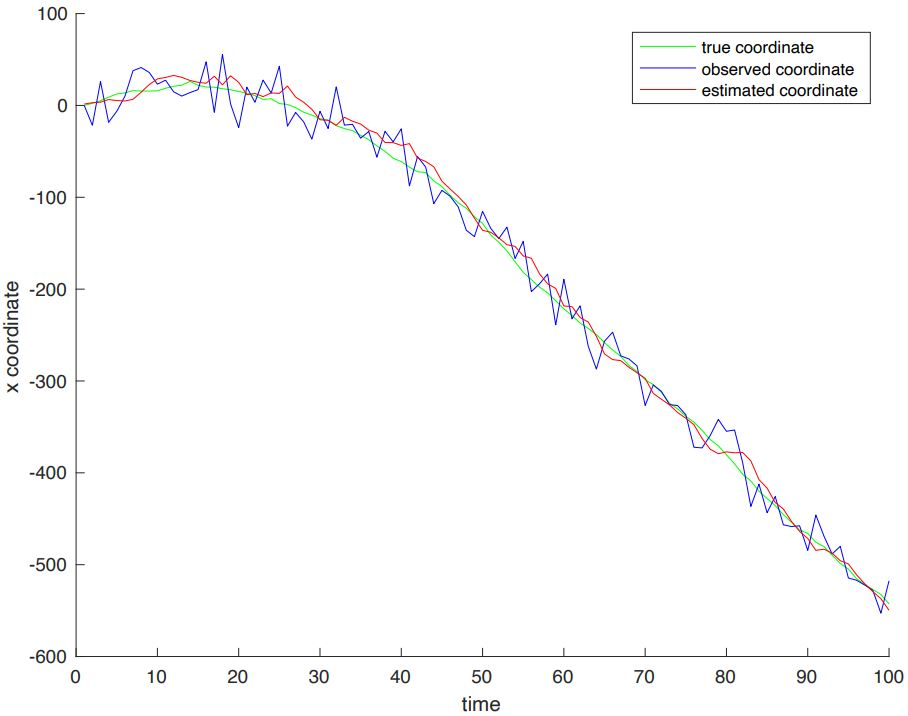

**Suggestion**: when implementing your Kalman filter, you will have to choose initial values for **$\mu_{t}$** and **$\Sigma_{t}$**. Provided that you do not make very unreasonable assumptions, the Kalman filter will update those estimates from observed data, so the initial choices are not very critical. 

Test your Kalman filter modifying the values of some of the parameters, including standard deviations **$\sigma_{Q}$** and **$\sigma_{R}$**, initial values for **$\mu_{t}$** and **$\Sigma_{t}$** and the value of **$\Delta$**.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%pip install pandas ndjson

import ndjson
import pandas as pd
import numpy as np

#Dataset origin: https://paperswithcode.com/dataset/trajnet-1
#The crowds_students001 file is loaded, and formatted as a list of numpy vectors

with open('./crowds_students001_trackonly.ndjson') as f:
  data = ndjson.load(f)

# data is a list of dictionaries as follows: {"track": {"f": int, "p": int, "x": float, "y": float}}
# f is the frame number, p is the person number, x and y are the coordinates of the person
# display(data)

p='-1'

person_dict = []

for ii in range(len(data)): # iterate over all the data
  if(p!=data[ii]['track']['p']):  # if the row is from a new person, create a new list for the positions of that person
    p=data[ii]['track']['p']
    person_dict.append([])
  person_dict[p].append((data[ii]['track']['x'],data[ii]['track']['y']))  # append the position of the person to the list
  # at the end we will have a list of lists, where each list is the trajectory of a person

# convert the list of lists to a list of numpy arrays
person_dict_numpy = []
for ii in range(148):  # select the first 148 people
  person_dict_numpy.append(np.array(person_dict[ii], dtype=float))

Note: you may need to restart the kernel to use updated packages.


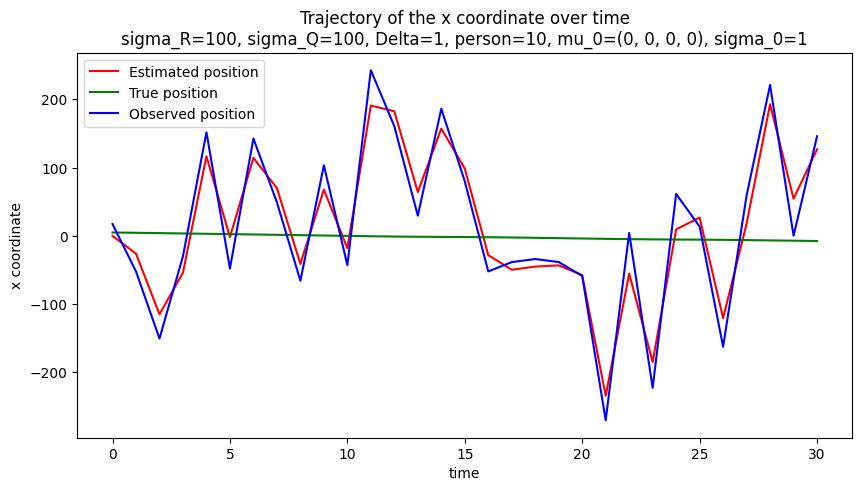

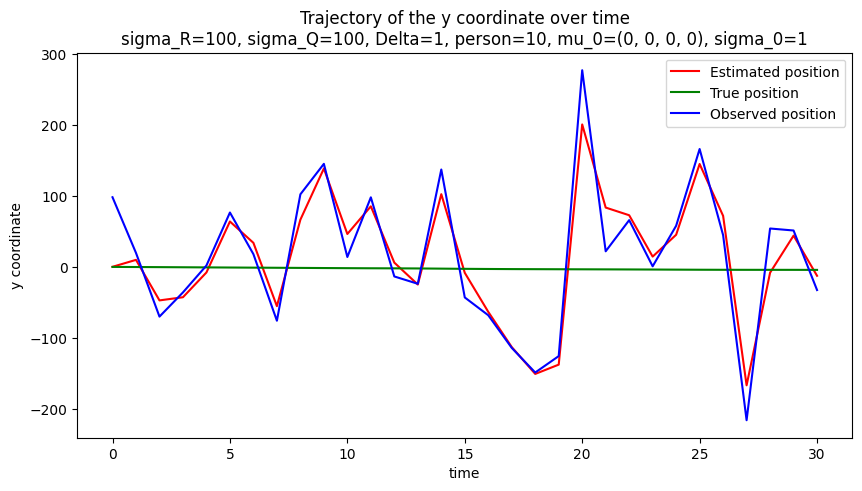

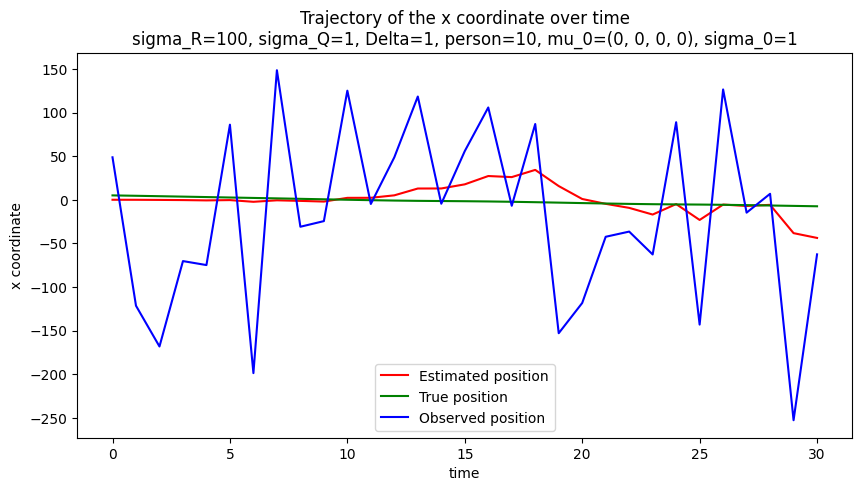

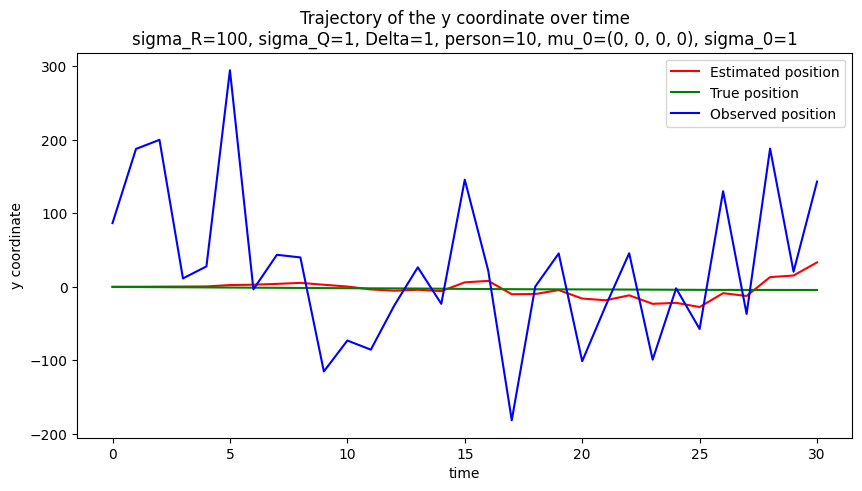

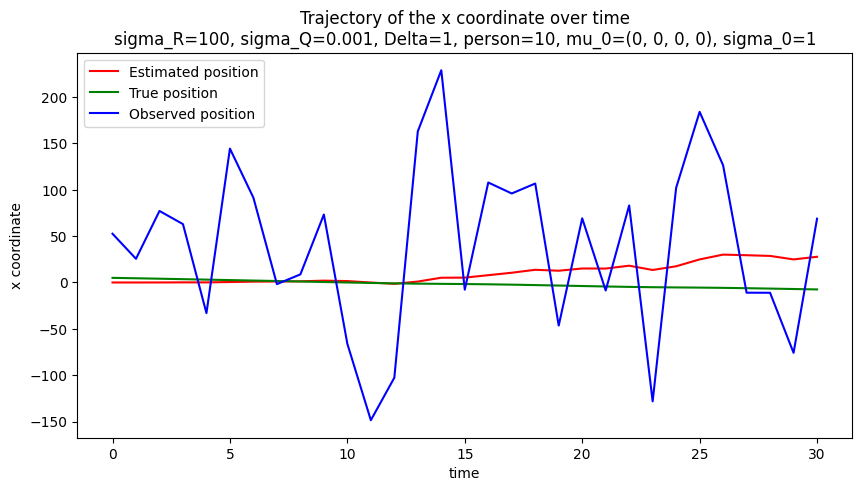

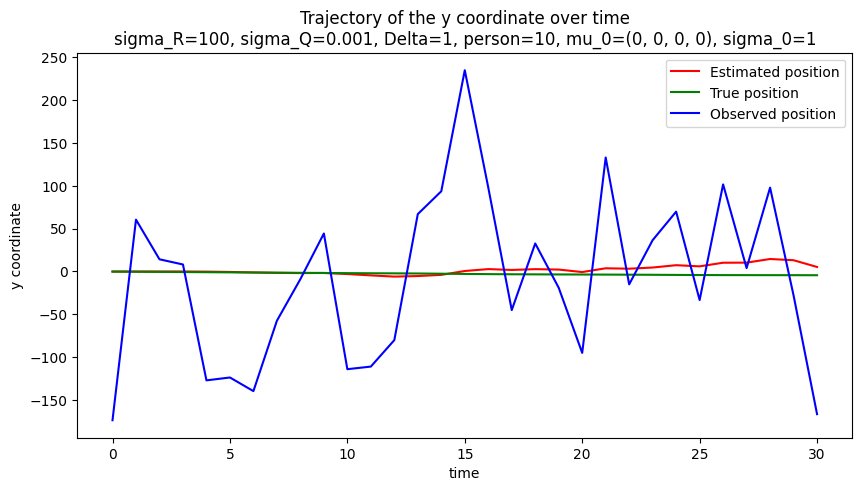

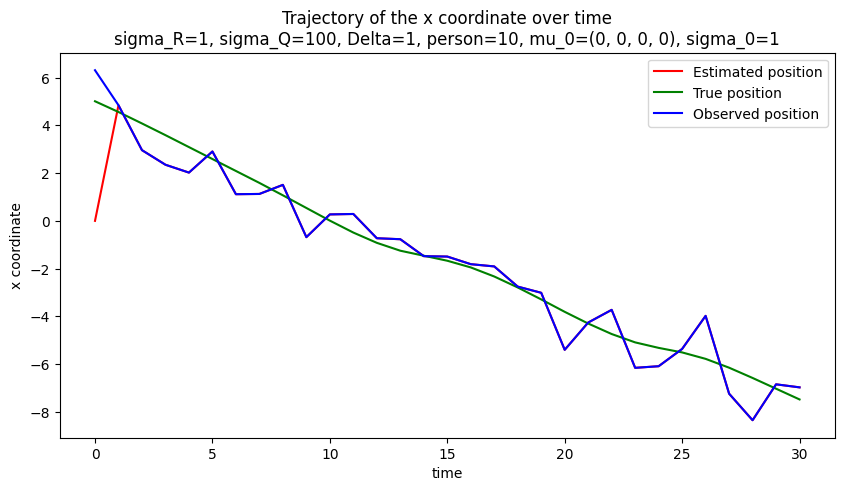

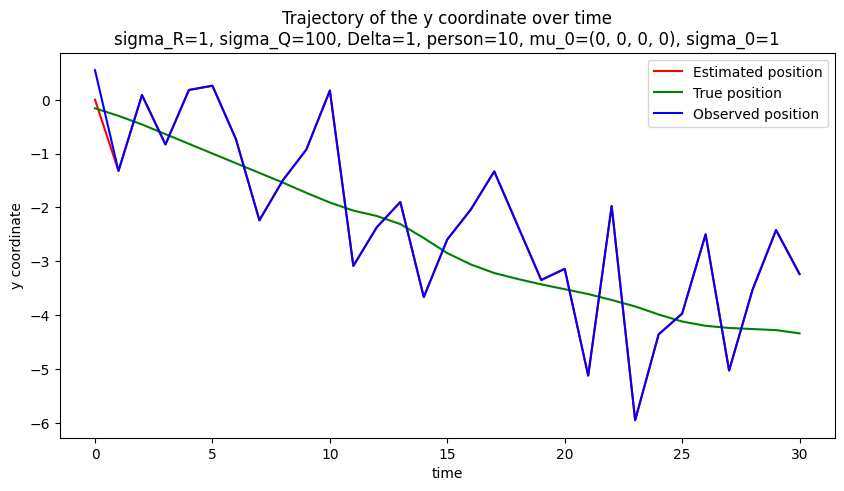

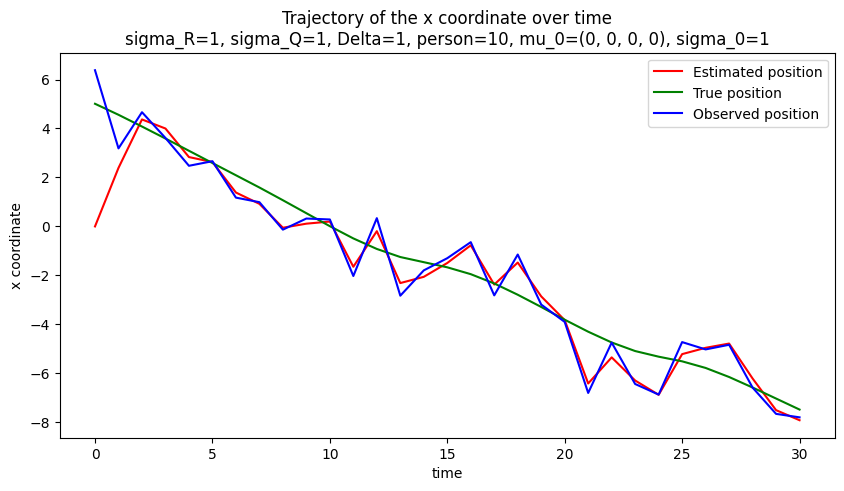

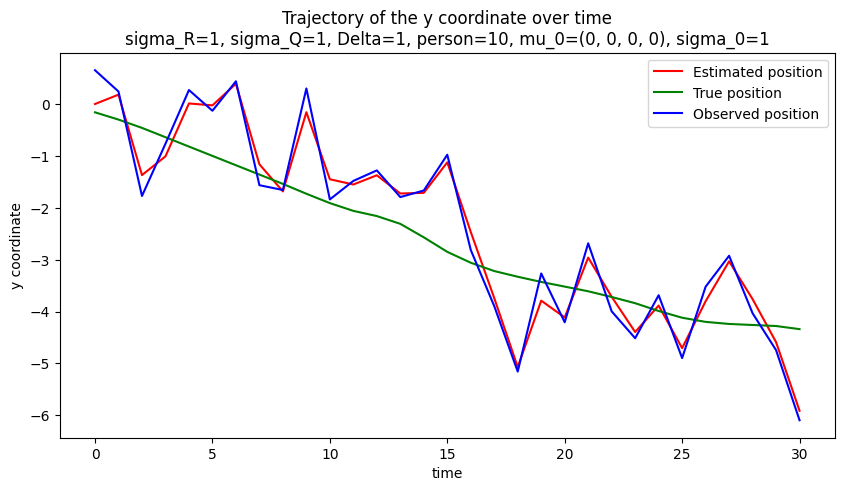

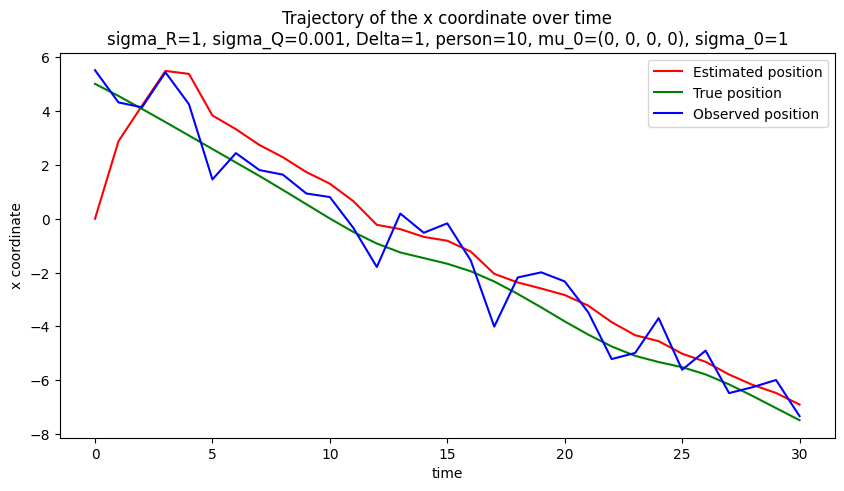

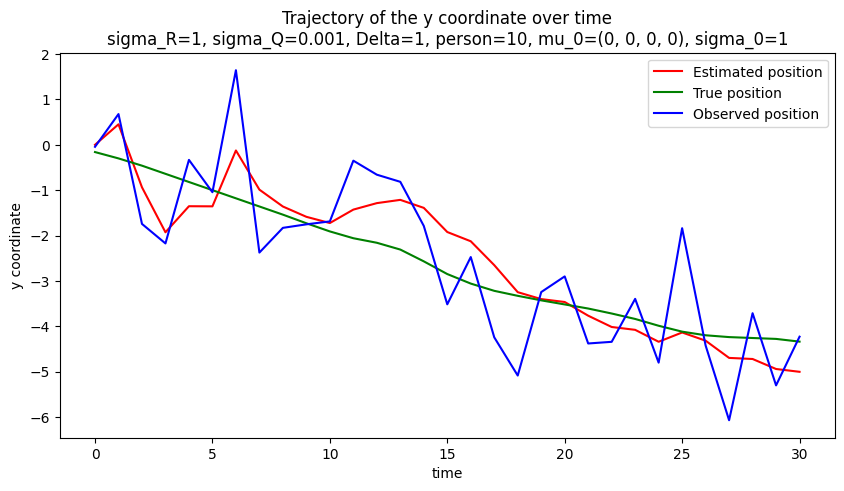

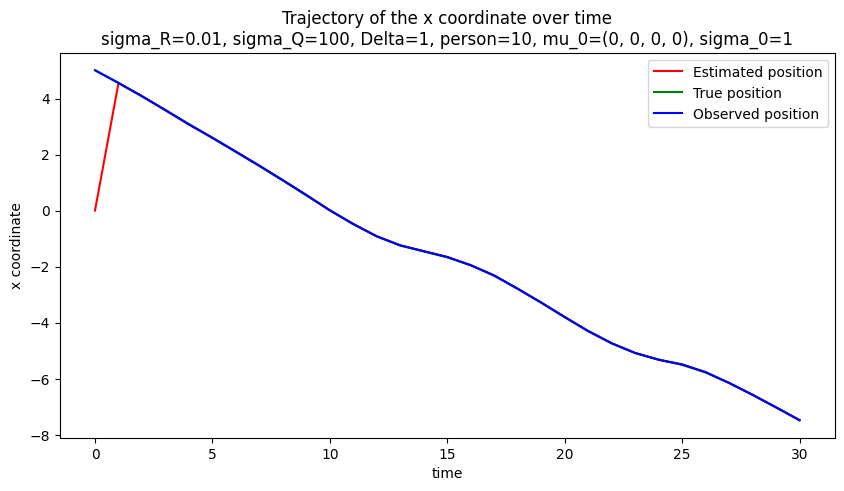

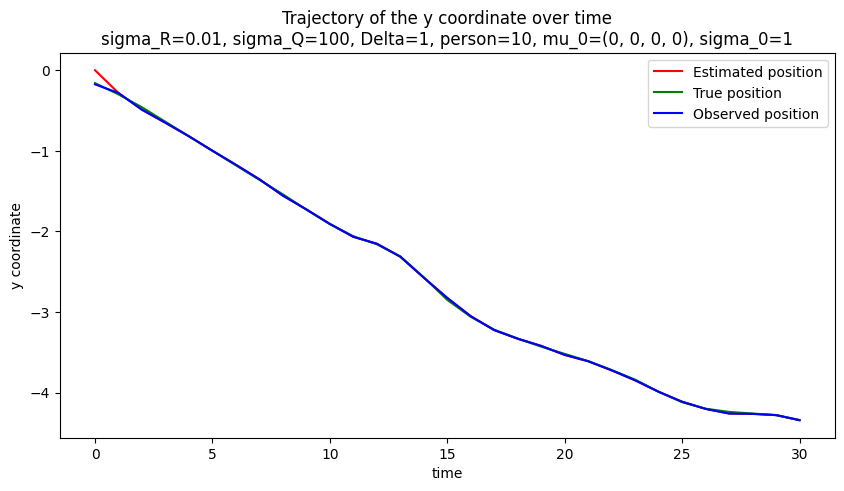

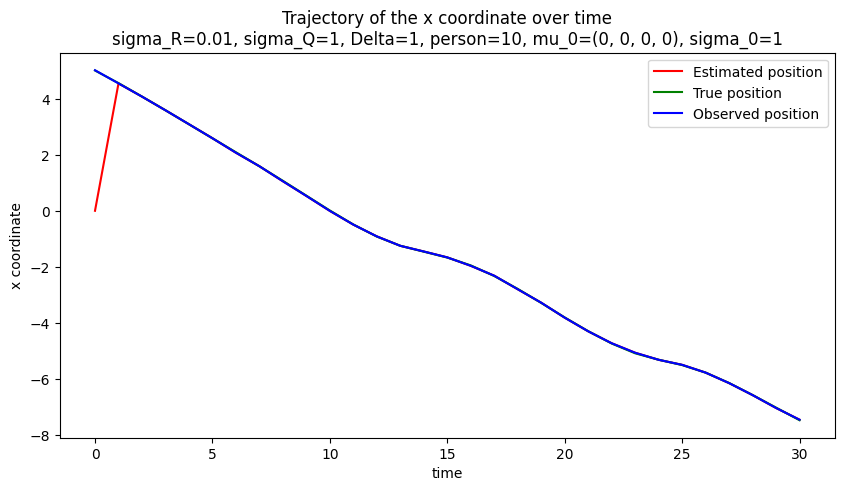

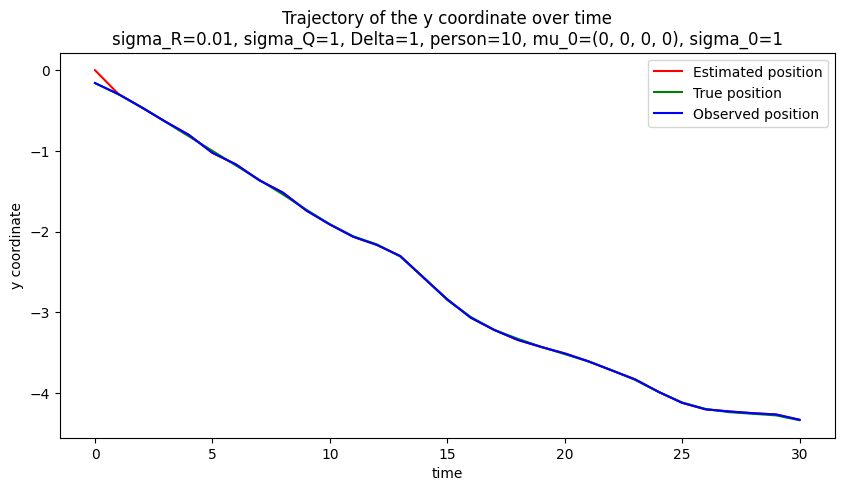

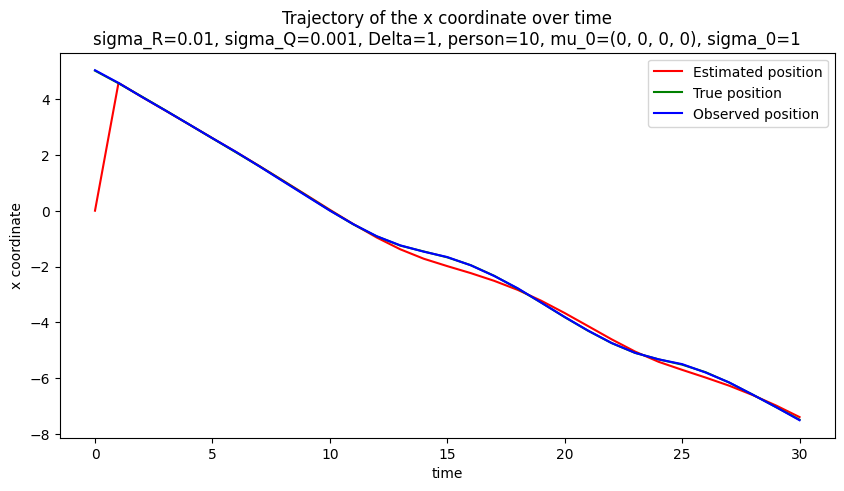

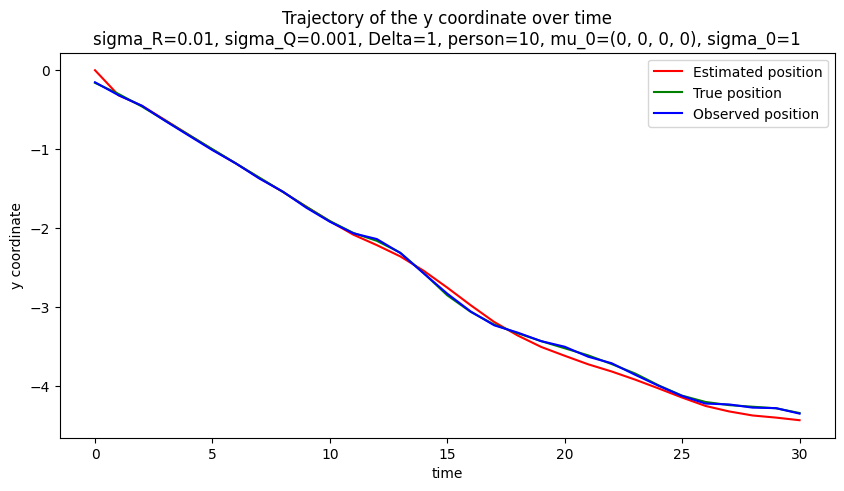

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Implement the kalman filter as a function using the numpy library, the matrix products can be done using the np.dot function
# The matrix inversion can be done using the np.linalg.inv    

def kalman_filter(y, mu_tmin1, sigma_tmin1, A, C, Q, R):
  # Predict the state at the next time step
  mu_est = np.dot(A, mu_tmin1)  # mu_t|t-1 = A_t*mu_t-1
  sigma_est = np.dot(np.dot(A, sigma_tmin1), A.T) + Q # sigma_t|t-1 = A_t * cov_t-1 * (A_t)^T + Q

  # Calculate the Kalman gain
  K = np.dot(np.dot(sigma_est, C.T), np.linalg.inv(np.dot(np.dot(C, sigma_est), C.T) + R))  # K_t = cov_t|t-1 * (C_t)^T * (C_t * cov_t|t-1 * (C_t)^T + R)^(-1)
  # Update the estimate of the state
  y_hat = np.dot(C, mu_est) # y_hat_t = C_t * mu_t|t-1
  r = y - y_hat # r_t = y_t - y_hat_t
  mu_est = mu_est + np.dot(K, r)  # mu_t = mu_t|t-1 + K_t * r_t
  # Update the estimate of the covariance
  sigma_est = np.dot(np.eye(4) - np.dot(K, C), sigma_est) # cov_t = (I - K_t * C_t) * cov_t|t-1

  return mu_est, sigma_est

# we decide which person to track by selecting a random index between 0 and 147
rand_index = random.randint(0,147) #choose a random index between 0 and 147
true_positions = person_dict_numpy[rand_index] #choose a single trajectory by taking an element of the list person_dict_numpy, select a random index between 0 and 148  

#Define parameter delta
Delta = 1 # constant velocity

# our state vector is: z_t = (s_1t, s_2t, v_1t, v_2t)^T -> we must multiply the state vector by the matrix A to get the state at the next time step
# this matrix rappresents the state transition model
A = np.array([[1, 0, Delta, 0],
             [0, 1, 0, Delta],
             [0, 0, 1, 0 ],
             [0, 0, 0, 1 ]])


# Define the measurement matrix - we measure the position, but not the velocity
C = np.array([[1, 0, 0, 0],  # x is measured directly
             [0, 1, 0, 0]]) # y is measured directly

# Set the standard deviation of the measurement noise

sigma_R = [100, 1, 0.01]  # standard deviation of the measurement noise - how much noise there is in the measurements
# high value of R means that the measurements are very noisy, so the observed position will be far from the true position and will have a high variance
# low value of R means that the measurements are very accurate, so the observed position will be close to the true position and will have a low variance

sigma_Q = [100, 1, 0.001]  # standard deviation of the system noise - how much trust we have in the estimatetions
# high value of Q means that we trust the measurements more than the model, so the estimated position will be closer to the observed position
# low value of Q means that we trust the model more than the measurements, so the estimated position will be far from the observed position

for sigma_r in sigma_R:
  for sigma_q in sigma_Q:
    # Define the process noise covariance matrix
    Q = (sigma_q**2)*np.eye(4)

    # Define the measurement noise covariance matrix
    R = (sigma_r**2)*np.eye(2)

    # Set the initial state and covariance
    mu_0 = (0, 0, 0, 0)  # initial position of the person
    sigma_0 = 1  # uncertainty in the initial position

    # Iterate over the observed coordinates
    mu = np.zeros([len(true_positions), 4])
    sigma = np.zeros([len(true_positions), 4, 4])
    mu[0] = mu_0
    sigma[0] = sigma_0*np.eye(4)
    y = np.zeros([len(true_positions), 2])
    y[0] = true_positions[0] + np.random.normal(0,sigma_r,2)
    for t in range(1,len(true_positions)):
      # Get the observed coordinates at time t 
      # Note: the observed position is simulated by adding gaussian noise to the true_positions
      y[t] = true_positions[t] + np.random.normal(0,sigma_r,2)
      #apply the kalman filter on the observed coordinates 
      mu_est, sigma_est = kalman_filter(y[t], mu_tmin1 = mu[t-1], sigma_tmin1 = sigma[t-1], A = A, C = C, Q = Q, R = R)
      mu[t] = mu_est
      sigma[t] = sigma_est

    #Use the matplotlib library to plot the true positions, observed positions y and the results of the kalman filtering
    #You should obtain a plot which resembles the one in the figure 
    #Plot the trajectory of the x coordinate over time and the trajectory of the y coordinate over time into two separate plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(mu[:,0], label='Estimated position', color='red')
    plt.plot(true_positions[:,0], label='True position', color='green')
    plt.plot(y[:,0], label='Observed position', color='blue')
    plt.xlabel('time')
    plt.ylabel('x coordinate')
    plt.legend()
    plt.title(f'Trajectory of the x coordinate over time\nsigma_R={sigma_r}, sigma_Q={sigma_q}, Delta={Delta}, person={rand_index}, mu_0={mu_0}, sigma_0={sigma_0}')
    plt.show()

    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(mu[:,1], label='Estimated position', color='red')
    plt.plot(true_positions[:,1], label='True position', color='green')
    plt.plot(y[:,1], label='Observed position', color='blue')
    plt.xlabel('time')
    plt.ylabel('y coordinate')
    plt.legend()
    plt.title(f'Trajectory of the y coordinate over time\nsigma_R={sigma_r}, sigma_Q={sigma_q}, Delta={Delta}, person={rand_index}, mu_0={mu_0}, sigma_0={sigma_0}') 
    plt.show()